In [1]:
# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [3]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [4]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [5]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [6]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [7]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [8]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
from keras.layers.normalization import BatchNormalization
import keras
tf.set_random_seed(42)

Using TensorFlow backend.


In [9]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [10]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [11]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM, Conv1D, Conv2D, TimeDistributed, MaxPooling1D,MaxPooling2D
from keras.layers.core import Dense, Dropout, Flatten

In [12]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [13]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [14]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [15]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))
print(n_classes)

128
9
7352
6


In [16]:
import pickle

# example_dict = {1:"6",2:"2",3:"f"}

pickle_out = open("X_train.pickle","wb")
pickle.dump(X_train, pickle_out)
pickle_out.close()

pickle_out = open("X_test.pickle","wb")
pickle.dump(X_test, pickle_out)
pickle_out.close()
pickle_out = open("Y_train.pickle","wb")
pickle.dump(Y_train, pickle_out)
pickle_out.close()
pickle_out = open("Y_test.pickle","wb")
pickle.dump(Y_test, pickle_out)
pickle_out.close()

- Defining the Architecture of LSTM

In [52]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 32)                5376      
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [53]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [54]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 32s 4ms/step - loss: 1.3981 - acc: 0.4308 - val_loss: 1.1674 - val_acc: 0.5165 - loss: 1.7060 - a - ETA: 31s - lo - ETA: 29s - loss:  - ETA: 28s - loss: 1.6683 - acc - ETA: 27s - loss: 1.6607 - - ETA: 24s - loss: 1.6325 - acc - ETA: 24s - loss: 1.6278 - acc: 0.34 - ETA: 24s - lo - ETA: 15s - loss:  - ETA: 14s - loss: 1.53 - ETA: 13s - loss: 1.5274 - acc: 0.37 - ETA: 13s - loss: 1.5269 - acc - ETA - ETA: 12s  - ETA: 11s - loss: 1.5046 - a - ETA: 10s - loss: 1.5011 - - ETA: 10s - loss: 1.4981 - acc:  - ETA: 10s - loss: 1.4965 - - ETA: 9s - loss: 1.4923 - ETA: 8s - loss: 1.4828 - acc:  - ETA: 8s - loss: 1.4798  - ETA: 5s - loss: 1.4494 - acc: 0.4 - ETA: 4s - lo - ETA: 3s - loss: 1.4289 - acc: - ETA: 2s - loss: 1.4227 - acc: 0.41 - ETA: 2s - loss: 1.4221 - acc:  - ETA: 2s - loss: 1.4169 - acc: 0 - ETA: 1s - loss: 1.4126 - acc: 0 - ETA: 1s - loss: 1.4099 - ac - ETA: 1s - loss: 1.40
Epoch 

7352/7352 [==============================] - 31s 4ms/step - loss: 0.2775 - acc: 0.9158 - val_loss: 0.4050 - val_acc: 0.8731A: 28s - loss: 0.2329 - ETA: 27s - loss: 0.2977 - a - ETA: 27s - loss: 0.2851 - a - ETA: 27s - loss: 0. - ETA: 26s - loss:  - ETA: 25s - loss: 0.3178 - acc: 0. - ETA: 25s  - ETA: 24s - loss: 0.3085 - acc: 0.90 - ETA: 24s  - - ETA: 21s - loss: 0.30 - ETA: 21s - loss: 0.3002 - acc: 0. - ETA: 21s - loss: 0.3018 - acc: 0.91 - ETA: 21 - ETA: 20s - loss: 0.30 - ETA: 18s - loss: 0.2938 - ETA: 16 - E - ETA: 13s - loss: 0.2932 - ETA: 12s - loss: 0.2909 - acc: 0. - ETA: 12s - loss: 0.2917 - acc: 0. - ETA: 12s - loss: 0.2927 - ETA: 12s - loss: 0. - ETA: 11s - los - ETA: 8s - loss:  - ETA: 7s - loss:  - ETA: 6s - loss: 0.2825 - acc: - E - ETA: 3s - loss: 0.2757 - acc: 0 - ETA: 3s - loss: 0.2745 - acc: - ETA: 2s - loss: 0.2774 - acc - ETA: 2s - loss: 0.2783 - acc:  - ETA: 2s - loss: 0.2775 - acc - ETA: 1s - loss: 0.2777 - ac - ETA: 0s - loss: 0.2772 - acc: - ETA: 0s - loss: 0.2

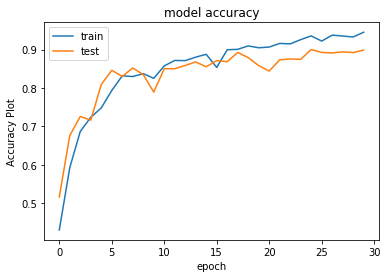

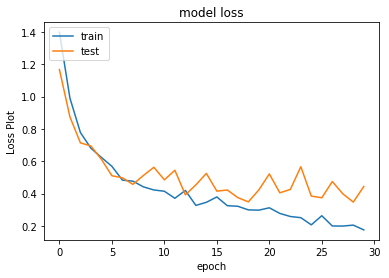

In [55]:
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [56]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0         0        0                   0   
SITTING                  1      365       105       19                   0   
STANDING                 0       57       462       13                   0   
WALKING                  0        0         0      480                   7   
WALKING_DOWNSTAIRS       0        1         0        6                 410   
WALKING_UPSTAIRS         0        0         0       49                   1   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            27  
SITTING                            1  
STANDING                           0  
WALKING                            9  
WALKING_DOWNSTAIRS                 3  
WALKING_UPSTAIRS                 421  


In [57]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 1s 407us/step


In [58]:
score

[0.4439637092944362, 0.8985408890397014]

- With a simple 2 layer architecture we got 90.09% accuracy and a loss of 0.30
- We can further imporve the performace with Hyperparameter tuning

## LSTM with 40 hidden layer

In [59]:
n_hidden = 40

In [68]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# model.add(LSTM(50, return_sequences=True))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 40)                8000      
_________________________________________________________________
dropout_14 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 246       
Total params: 8,246
Trainable params: 8,246
Non-trainable params: 0
_________________________________________________________________


In [69]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [70]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 178s 24ms/step - loss: 1.3302 - acc: 0.4211 - val_loss: 1.1643 - val_acc: 0.4683
Epoch 2/30
7352/7352 [==============================] - 191s 26ms/step - loss: 0.9893 - acc: 0.5781 - val_loss: 0.9215 - val_acc: 0.6247
Epoch 3/30
7352/7352 [==============================] - 192s 26ms/step - loss: 0.8139 - acc: 0.6318 - val_loss: 0.8111 - val_acc: 0.6227
Epoch 4/30
7352/7352 [==============================] - 162s 22ms/step - loss: 0.7393 - acc: 0.6496 - val_loss: 0.8100 - val_acc: 0.6118
Epoch 5/30
7352/7352 [==============================] - 162s 22ms/step - loss: 0.6842 - acc: 0.6715 - val_loss: 0.8431 - val_acc: 0.6301
Epoch 6/30
7352/7352 [==============================] - 162s 22ms/step - loss: 0.6472 - acc: 0.7048 - val_loss: 0.7020 - val_acc: 0.7119
Epoch 7/30
7352/7352 [==============================] - 163s 22ms/step - loss: 0.6363 - acc: 0.7515 - val_loss: 0.6432 - val_acc: 

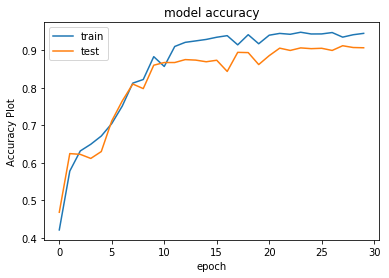

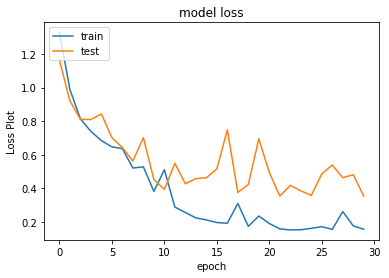

In [71]:
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [72]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 537        0         0        0                   0   
SITTING                  2      403        83        2                   0   
STANDING                 0       91       438        2                   0   
WALKING                  0        0         0      462                   5   
WALKING_DOWNSTAIRS       0        2         0        5                 380   
WALKING_UPSTAIRS         0        0         1       17                   0   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            1  
STANDING                           1  
WALKING                           29  
WALKING_DOWNSTAIRS                33  
WALKING_UPSTAIRS                 453  


In [73]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 6s 2ms/step


In [74]:
score

[0.35390040830584885, 0.9070240922972514]

In [16]:
n_hidden1 = 50

In [112]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden1, input_shape=(timesteps, input_dim)))
# model.add(LSTM(50, return_sequences=True))
# Adding a dropout layer
model.add(Dropout(0.6))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 50)                12000     
_________________________________________________________________
dropout_26 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 6)                 306       
Total params: 12,306
Trainable params: 12,306
Non-trainable params: 0
_________________________________________________________________


In [113]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [114]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 68s 9ms/step - loss: 1.1511 - acc: 0.5216 - val_loss: 0.8752 - val_acc: 0.6423
Epoch 2/30
7352/7352 [==============================] - 65s 9ms/step - loss: 0.7443 - acc: 0.6865 - val_loss: 0.7961 - val_acc: 0.7150
Epoch 3/30
7352/7352 [==============================] - 72s 10ms/step - loss: 0.5828 - acc: 0.7824 - val_loss: 0.6692 - val_acc: 0.7872
Epoch 4/30
7352/7352 [==============================] - 67s 9ms/step - loss: 0.4235 - acc: 0.8656 - val_loss: 0.5199 - val_acc: 0.8181
Epoch 5/30
7352/7352 [==============================] - 64s 9ms/step - loss: 0.3237 - acc: 0.8966 - val_loss: 0.3509 - val_acc: 0.8924
Epoch 6/30
7352/7352 [==============================] - 68s 9ms/step - loss: 0.2606 - acc: 0.9157 - val_loss: 0.4338 - val_acc: 0.8826
Epoch 7/30
7352/7352 [==============================] - 69s 9ms/step - loss: 0.2274 - acc: 0.9270 - val_loss: 0.2570 - val_acc: 0.8972
Epoch 

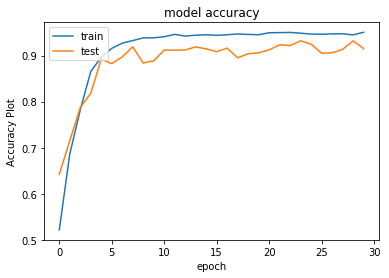

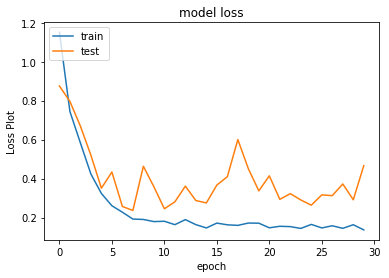

In [115]:
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [116]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0        27        0                   0   
SITTING                  0      363       126        0                   0   
STANDING                 0       48       484        0                   0   
WALKING                  1        0         0      470                   1   
WALKING_DOWNSTAIRS       0        0         0        9                 402   
WALKING_UPSTAIRS         0        2         0        1                   0   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            2  
STANDING                           0  
WALKING                           24  
WALKING_DOWNSTAIRS                 9  
WALKING_UPSTAIRS                 468  


In [117]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 1s 501us/step ETA: 


In [118]:
score

[0.46645971163931743, 0.9151679674244995]

In [128]:
n_hidden2 = 60

In [129]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden2, input_shape=(timesteps, input_dim)))
# model.add(LSTM(50, return_sequences=True))
# Adding a dropout layer
model.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 60)                16800     
_________________________________________________________________
dropout_29 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 6)                 366       
Total params: 17,166
Trainable params: 17,166
Non-trainable params: 0
_________________________________________________________________


In [130]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [131]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 46s 6ms/step - loss: 1.1906 - acc: 0.4992 - val_loss: 1.0830 - val_acc: 0.5341
Epoch 2/30
7352/7352 [==============================] - 40s 5ms/step - loss: 0.8087 - acc: 0.6812 - val_loss: 0.7481 - val_acc: 0.6926
Epoch 3/30
7352/7352 [==============================] - 38s 5ms/step - loss: 0.5655 - acc: 0.7907 - val_loss: 0.5862 - val_acc: 0.8178
Epoch 4/30
7352/7352 [==============================] - 38s 5ms/step - loss: 0.3822 - acc: 0.8847 - val_loss: 0.6419 - val_acc: 0.8314
Epoch 5/30
7352/7352 [==============================] - 38s 5ms/step - loss: 0.2945 - acc: 0.9110 - val_loss: 0.5544 - val_acc: 0.8626
Epoch 6/30
7352/7352 [==============================] - 38s 5ms/step - loss: 0.2849 - acc: 0.9197 - val_loss: 0.5928 - val_acc: 0.8673
Epoch 7/30
7352/7352 [==============================] - 38s 5ms/step - loss: 0.2216 - acc: 0.9272 - val_loss: 0.5731 - val_acc: 0.8744
Epoch 8

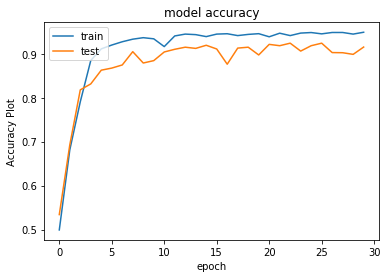

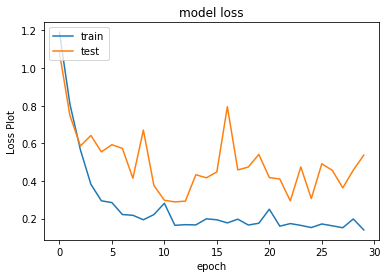

In [132]:
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [133]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0        27        0                   0   
SITTING                  0      377       112        0                   0   
STANDING                 0       56       476        0                   0   
WALKING                  0        0         0      460                  33   
WALKING_DOWNSTAIRS       0        2         0        2                 416   
WALKING_UPSTAIRS         0        0         1       10                   2   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            2  
STANDING                           0  
WALKING                            3  
WALKING_DOWNSTAIRS                 0  
WALKING_UPSTAIRS                 458  


In [134]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 2s 632us/step


In [135]:
score

[0.5372093813093824, 0.9151679674244995]

In [92]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(BatchNormalization())
model.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 40)                8000      
_________________________________________________________________
batch_normalization_2 (Batch (None, 40)                160       
_________________________________________________________________
dropout_22 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 246       
Total params: 8,406
Trainable params: 8,326
Non-trainable params: 80
_________________________________________________________________


In [93]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [94]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 70s 9ms/step - loss: 1.2924 - acc: 0.4927 - val_loss: 0.9264 - val_acc: 0.6335
Epoch 2/30
7352/7352 [==============================] - 66s 9ms/step - loss: 0.8858 - acc: 0.6012 - val_loss: 0.7590 - val_acc: 0.5870
Epoch 3/30
7352/7352 [==============================] - 61s 8ms/step - loss: 0.7781 - acc: 0.6253 - val_loss: 0.7301 - val_acc: 0.5789
Epoch 4/30
7352/7352 [==============================] - 61s 8ms/step - loss: 0.7432 - acc: 0.6394 - val_loss: 0.7625 - val_acc: 0.6254
Epoch 5/30
7352/7352 [==============================] - 63s 9ms/step - loss: 0.7140 - acc: 0.6412 - val_loss: 0.7847 - val_acc: 0.5792
Epoch 6/30
7352/7352 [==============================] - 58s 8ms/step - loss: 0.6763 - acc: 0.6555 - val_loss: 0.7683 - val_acc: 0.5972
Epoch 7/30
7352/7352 [==============================] - 58s 8ms/step - loss: 0.6804 - acc: 0.6506 - val_loss: 0.6837 - val_acc: 0.5894
Epoch 8

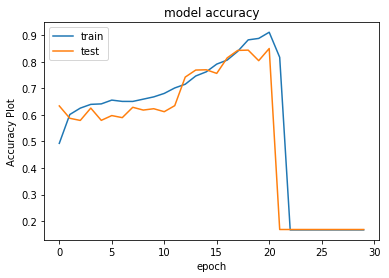

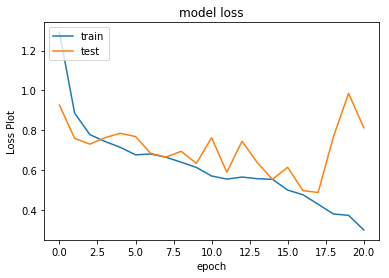

In [95]:
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [96]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                WALKING
True                       
LAYING                  537
SITTING                 491
STANDING                532
WALKING                 496
WALKING_DOWNSTAIRS      420
WALKING_UPSTAIRS        471


In [97]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 2s 691us/step


In [98]:
score

[nan, 0.168306752629793]

# 2 Layer LSTM

In [76]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(int(n_hidden/2)))
# Adding a dropout layer
model.add(Dropout(0.6))
# Adding a dense output layer with softmax activation
model.add(Dense(n_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 128, 40)           8000      
_________________________________________________________________
dropout_17 (Dropout)         (None, 128, 40)           0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 20)                4880      
_________________________________________________________________
dropout_18 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 126       
Total params: 13,006
Trainable params: 13,006
Non-trainable params: 0
_________________________________________________________________


In [77]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [78]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 392s 53ms/step - loss: 1.2292 - acc: 0.4770 - val_loss: 0.8710 - val_acc: 0.6451
Epoch 2/30
7352/7352 [==============================] - 373s 51ms/step - loss: 0.7650 - acc: 0.7087 - val_loss: 0.8494 - val_acc: 0.6807
Epoch 3/30
7352/7352 [==============================] - 350s 48ms/step - loss: 0.6214 - acc: 0.7788 - val_loss: 0.6094 - val_acc: 0.7842
Epoch 4/30
7352/7352 [==============================] - 396s 54ms/step - loss: 0.5320 - acc: 0.8312 - val_loss: 0.5385 - val_acc: 0.8015
Epoch 5/30
7352/7352 [==============================] - 348s 47ms/step - loss: 0.4450 - acc: 0.8663 - val_loss: 0.4626 - val_acc: 0.8541
Epoch 6/30
7352/7352 [==============================] - 347s 47ms/step - loss: 0.3489 - acc: 0.8962 - val_loss: 0.5041 - val_acc: 0.8568
Epoch 7/30
7352/7352 [==============================] - 396s 54ms/step - loss: 0.3124 - acc: 0.9089 - val_loss: 0.4310 - val_acc: 

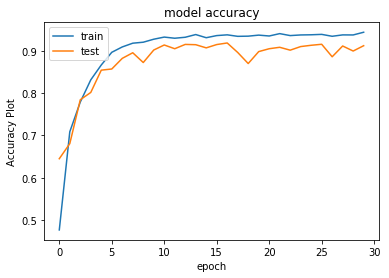

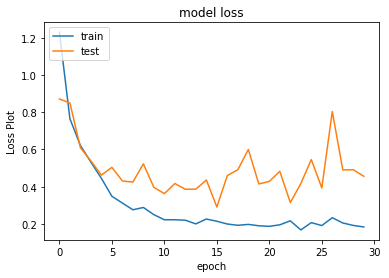

In [79]:
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [80]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0         0        0                   0   
SITTING                  0      417        46       25                   2   
STANDING                 0       98       429        5                   0   
WALKING                  7        1         0      468                  19   
WALKING_DOWNSTAIRS       1        0         0        5                 412   
WALKING_UPSTAIRS         1        3         0       16                   0   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            27  
SITTING                            1  
STANDING                           0  
WALKING                            1  
WALKING_DOWNSTAIRS                 2  
WALKING_UPSTAIRS                 451  


In [81]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 18s 6ms/step


In [82]:
score

[0.4561463569550516, 0.9117746861214795]

In [99]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim), return_sequences=True))
model.add(Dropout(0.6))
model.add(LSTM(int(n_hidden/2)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 128, 40)           8000      
_________________________________________________________________
dropout_23 (Dropout)         (None, 128, 40)           0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 20)                4880      
_________________________________________________________________
dropout_24 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 6)                 126       
Total params: 13,006
Trainable params: 13,006
Non-trainable params: 0
_________________________________________________________________


In [100]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [101]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 132s 18ms/step - loss: 1.3653 - acc: 0.4090 - val_loss: 1.2027 - val_acc: 0.4917
Epoch 2/30
7352/7352 [==============================] - 141s 19ms/step - loss: 0.9982 - acc: 0.5869 - val_loss: 1.0195 - val_acc: 0.5358
Epoch 3/30
7352/7352 [==============================] - 118s 16ms/step - loss: 0.8134 - acc: 0.6274 - val_loss: 0.8334 - val_acc: 0.6125
Epoch 4/30
7352/7352 [==============================] - 125s 17ms/step - loss: 0.7750 - acc: 0.6446 - val_loss: 0.7550 - val_acc: 0.6335
Epoch 5/30
7352/7352 [==============================] - 148s 20ms/step - loss: 0.7105 - acc: 0.6866 - val_loss: 0.6939 - val_acc: 0.7068
Epoch 6/30
7352/7352 [==============================] - 129s 18ms/step - loss: 0.6135 - acc: 0.7495 - val_loss: 0.6475 - val_acc: 0.7587
Epoch 7/30
7352/7352 [==============================] - 132s 18ms/step - loss: 0.5485 - acc: 0.8069 - val_loss: 0.5688 - val_acc: 

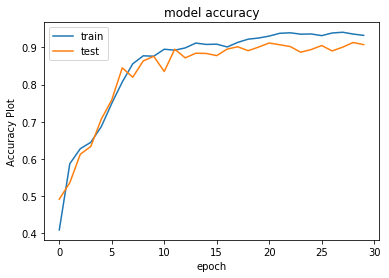

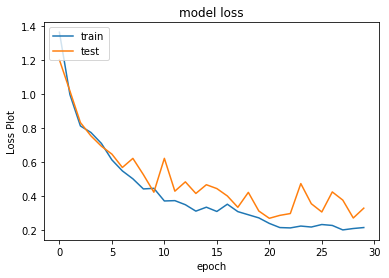

In [102]:
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [103]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 519        0        17        0                   0   
SITTING                  0      382       107        0                   1   
STANDING                 0       74       456        2                   0   
WALKING                  0        0         3      480                   0   
WALKING_DOWNSTAIRS       0        0         0       13                 407   
WALKING_UPSTAIRS         0        0         0       29                  12   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             1  
SITTING                            1  
STANDING                           0  
WALKING                           13  
WALKING_DOWNSTAIRS                 0  
WALKING_UPSTAIRS                 430  


In [104]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 5s 2ms/step


In [105]:
score

[0.3290853972857961, 0.9073634204275535]

In [ ]:
# Model with 50 layers

In [142]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden1, input_shape=(timesteps, input_dim), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(int(n_hidden1/2)))
# Adding a dropout layer
model.add(Dropout(0.6))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 128, 50)           12000     
_________________________________________________________________
dropout_32 (Dropout)         (None, 128, 50)           0         
_________________________________________________________________
lstm_40 (LSTM)               (None, 25)                7600      
_________________________________________________________________
dropout_33 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 6)                 156       
Total params: 19,756
Trainable params: 19,756
Non-trainable params: 0
_________________________________________________________________


In [120]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [121]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 71s 10ms/step - loss: 1.3404 - acc: 0.4018 - val_loss: 1.1261 - val_acc: 0.4818
Epoch 2/30
7352/7352 [==============================] - 67s 9ms/step - loss: 1.0103 - acc: 0.5770 - val_loss: 1.0205 - val_acc: 0.5850
Epoch 3/30
7352/7352 [==============================] - 68s 9ms/step - loss: 0.8851 - acc: 0.6155 - val_loss: 0.7943 - val_acc: 0.6485
Epoch 4/30
7352/7352 [==============================] - 67s 9ms/step - loss: 0.8096 - acc: 0.6405 - val_loss: 0.7860 - val_acc: 0.6685
Epoch 5/30
7352/7352 [==============================] - 67s 9ms/step - loss: 0.7669 - acc: 0.6511 - val_loss: 0.7859 - val_acc: 0.6332
Epoch 6/30
7352/7352 [==============================] - 67s 9ms/step - loss: 0.7412 - acc: 0.6479 - val_loss: 0.7548 - val_acc: 0.6804
Epoch 7/30
7352/7352 [==============================] - 67s 9ms/step - loss: 0.7398 - acc: 0.6506 - val_loss: 1.3870 - val_acc: 0.5636
Epoch 

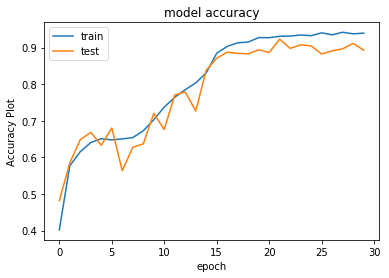

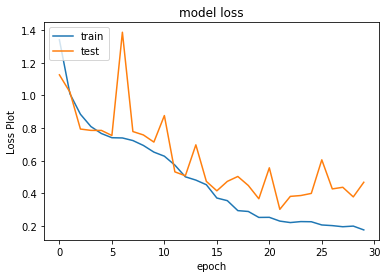

In [122]:
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [123]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 511        0        24        0                   0   
SITTING                  3      417        68        1                   1   
STANDING                 1       89       440        1                   0   
WALKING                  0        0         0      466                  30   
WALKING_DOWNSTAIRS       0        0         0        1                 419   
WALKING_UPSTAIRS         3        0         0       32                  57   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             2  
SITTING                            1  
STANDING                           1  
WALKING                            0  
WALKING_DOWNSTAIRS                 0  
WALKING_UPSTAIRS                 379  


In [124]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 6s 2ms/step


In [125]:
score

[0.4684253537972378, 0.8931116389548693]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 128, 60)           16800     
_________________________________________________________________
dropout_30 (Dropout)         (None, 128, 60)           0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 25)                8600      
_________________________________________________________________
dropout_31 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 6)                 156       
Total params: 25,556
Trainable params: 25,556
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 79s 11ms/step - loss: 1.3578 - acc

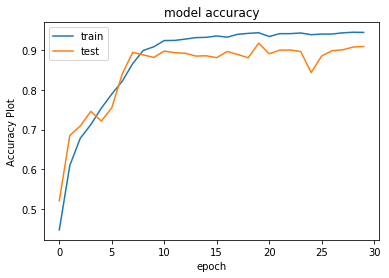

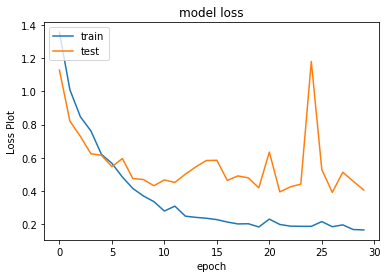

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0         0        0                   0   
SITTING                  5      388        92        1                   0   
STANDING                 0       80       451        1                   0   
WALKING                  0        0         1      465                  26   
WALKING_DOWNSTAIRS       0        0         0        4                 408   
WALKING_UPSTAIRS         0        3         0        4                   7   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            27  
SITTING                            5  
STANDING                           0  
WALKING                            4  
WALKING_DOWNSTAIRS                 8  
WALKING_UPSTAIRS                 457  
2947/2947 [==============================] - 7s 2ms/step


[0.4046179651593779, 0.9090600610790635]

In [136]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden2, input_shape=(timesteps, input_dim), return_sequences=True))
model.add(Dropout(0.7))
model.add(LSTM(int(n_hidden1/2)))
# Adding a dropout layer
model.add(Dropout(0.6))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

score = model.evaluate(X_test, Y_test)

score

# CNN + RNN

In [160]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


In [19]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(TimeDistributed(Conv1D(filters = 64, kernel_size=4,
                 activation='relu',padding = 'same'), input_shape = (timesteps,input_dim,1)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2,padding = 'same')))
model.add(TimeDistributed(Dropout(0.5)))

model.add(TimeDistributed(Conv1D(filters = 128, kernel_size=4,
                 activation='relu',padding = 'same')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2,padding = 'same')))
model.add(TimeDistributed(Flatten()))
model.add(Dropout(0.8))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.8))
model.add(LSTM(128))
# Adding a dropout layer
model.add(Dropout(0.6))
# Adding a dense output layer with sigmoid activation
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 128, 9, 64)        320       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 128, 5, 64)        0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 128, 5, 64)        0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 128, 5, 128)       32896     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 128, 3, 128)       0         
_________________________________________________________________
time_distributed_6 (T

In [20]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [17]:
x_train = X_train.reshape(len(X_train), len(X_train[0]), len(X_train[0][0]),1)
x_test = X_test.reshape(len(X_test),len(X_test[0]),len(X_test[0][0]),1)

In [18]:
print(x_train.shape)
print(x_test.shape)

(7352, 128, 9, 1)
(2947, 128, 9, 1)


In [20]:
len(X_test[0][0])

9

In [21]:
# Training the model
history = model.fit(x_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(x_test, Y_test),
          epochs=epochs)

Instructions for updating:
Use tf.cast instead.
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 469s 64ms/step - loss: 1.5916 - acc: 0.3010 - val_loss: 1.3614 - val_acc: 0.3627
Epoch 2/30
7352/7352 [==============================] - 456s 62ms/step - loss: 1.3251 - acc: 0.3881 - val_loss: 1.3328 - val_acc: 0.3614
Epoch 3/30
7352/7352 [==============================] - 488s 66ms/step - loss: 1.4490 - acc: 0.3868 - val_loss: 1.7856 - val_acc: 0.1805
Epoch 4/30
7352/7352 [==============================] - 492s 67ms/step - loss: 1.3448 - acc: 0.4049 - val_loss: 1.3569 - val_acc: 0.3505
Epoch 5/30
7352/7352 [==============================] - 496s 67ms/step - loss: 1.3393 - acc: 0.3721 - val_loss: 1.3219 - val_acc: 0.3729
Epoch 6/30
7352/7352 [==============================] - 495s 67ms/step - loss: 1.3041 - acc: 0.3969 - val_loss: 1.3129 - val_acc: 0.3760
Epoch 7/30
7352/7352 [==============================] - 491s 67ms/step - loss: 1.2

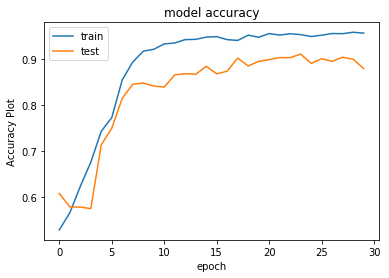

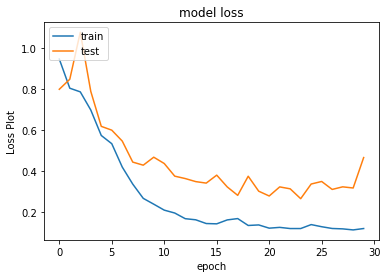

In [23]:
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(x_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0         0        0                   0   
SITTING                  1      402        83        0                   1   
STANDING                 0      104       427        1                   0   
WALKING                  0        0         0      419                  73   
WALKING_DOWNSTAIRS       0        0         0        0                 418   
WALKING_UPSTAIRS         1        0         0        0                  55   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            27  
SITTING                            4  
STANDING                           0  
WALKING                            4  
WALKING_DOWNSTAIRS                 2  
WALKING_UPSTAIRS                 415  


In [27]:
score = model.evaluate(x_test, Y_test)

2947/2947 [==============================] - 14s 5ms/step


In [28]:
score

[0.46598935046988216, 0.8791991856124872]

In [30]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(TimeDistributed(Conv1D(filters = 512, kernel_size=2,
                 activation='relu'), input_shape = (timesteps,input_dim,1)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Dropout(0.7)))

model.add(TimeDistributed(Conv1D(filters = 128, kernel_size=3,
                 activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Dropout(0.5)))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(150, return_sequences=True))
model.add(Dropout(0.8))
model.add(LSTM(50))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_9 (TimeDist (None, 128, 8, 512)       1536      
_________________________________________________________________
time_distributed_10 (TimeDis (None, 128, 4, 512)       0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 128, 4, 512)       0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, 128, 2, 128)       196736    
_________________________________________________________________
time_distributed_13 (TimeDis (None, 128, 1, 128)       0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, 128, 1, 128)       0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 128, 128)          0         
__________

In [31]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [32]:
# Training the model
history = model.fit(x_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(x_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 1259s 171ms/step - loss: 1.0633 - acc: 0.4697 - val_loss: 0.7920 - val_acc: 0.6386
Epoch 2/30
7352/7352 [==============================] - 1280s 174ms/step - loss: 0.7588 - acc: 0.5905 - val_loss: 0.7915 - val_acc: 0.5602
Epoch 3/30
7352/7352 [==============================] - 1275s 173ms/step - loss: 0.7042 - acc: 0.6485 - val_loss: 0.7370 - val_acc: 0.6196
Epoch 4/30
7352/7352 [==============================] - 1092s 149ms/step - loss: 0.6313 - acc: 0.6923 - val_loss: 0.7570 - val_acc: 0.6417
Epoch 5/30
7352/7352 [==============================] - 676s 92ms/step - loss: 0.6517 - acc: 0.7053 - val_loss: 0.7676 - val_acc: 0.6695
Epoch 6/30
7352/7352 [==============================] - 678s 92ms/step - loss: 0.5438 - acc: 0.7588 - val_loss: 0.7047 - val_acc: 0.7072
Epoch 7/30
7352/7352 [==============================] - 675s 92ms/step - loss: 0.4726 - acc: 0.8040 - val_loss: 0.8804 - v

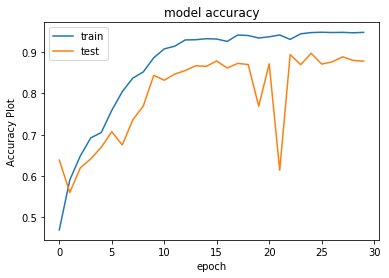

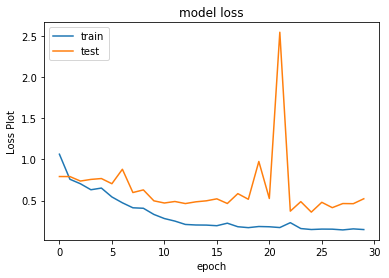

In [33]:
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(x_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 496        0         0        0                   0   
SITTING                  1      399        84        0                   0   
STANDING                 0      103       427        0                   0   
WALKING                  0        0         0      464                  18   
WALKING_DOWNSTAIRS       0        0         0       29                 374   
WALKING_UPSTAIRS         0        0         0        9                  35   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            41  
SITTING                            7  
STANDING                           2  
WALKING                           14  
WALKING_DOWNSTAIRS                17  
WALKING_UPSTAIRS                 427  


In [35]:
score = model.evaluate(x_test, Y_test)

2947/2947 [==============================] - 27s 9ms/step


In [36]:
score

[0.5217122400363511, 0.8778418730912793]

In [17]:
from keras.layers.normalization import BatchNormalization

In [38]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(TimeDistributed(Conv1D(filters = 512, kernel_size=2,
                 activation='relu'), input_shape = (timesteps,input_dim,1)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Dropout(0.7)))

model.add(TimeDistributed(Conv1D(filters = 128, kernel_size=3,
                 activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.5)))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(150, return_sequences=True))
model.add(Dropout(0.8))
model.add(LSTM(50))
# Adding a dropout layer
# model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, 128, 8, 512)       1536      
_________________________________________________________________
time_distributed_17 (TimeDis (None, 128, 4, 512)       0         
_________________________________________________________________
time_distributed_18 (TimeDis (None, 128, 4, 512)       0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 128, 2, 128)       196736    
_________________________________________________________________
time_distributed_20 (TimeDis (None, 128, 1, 128)       0         
_________________________________________________________________
time_distributed_21 (TimeDis (None, 128, 1, 128)       512       
_________________________________________________________________
time_distributed_22 (TimeDis (None, 128, 1, 128)       0         
__________

In [39]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [40]:
# Training the model
history = model.fit(x_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(x_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 685s 93ms/step - loss: 0.5618 - acc: 0.7703 - val_loss: 0.5549 - val_acc: 0.7947
Epoch 2/30
7352/7352 [==============================] - 679s 92ms/step - loss: 0.2491 - acc: 0.9132 - val_loss: 0.3537 - val_acc: 0.8741
Epoch 3/30
7352/7352 [==============================] - 681s 93ms/step - loss: 0.2165 - acc: 0.9197 - val_loss: 0.3541 - val_acc: 0.8890
Epoch 4/30
7352/7352 [==============================] - 680s 92ms/step - loss: 0.1698 - acc: 0.9324 - val_loss: 0.4782 - val_acc: 0.8683
Epoch 5/30
7352/7352 [==============================] - 6228s 847ms/step - loss: 0.1634 - acc: 0.9393 - val_loss: 0.4872 - val_acc: 0.8595
Epoch 6/30
7352/7352 [==============================] - 1284s 175ms/step - loss: 0.1574 - acc: 0.9382 - val_loss: 0.2978 - val_acc: 0.9091
Epoch 7/30
7352/7352 [==============================] - 1243s 169ms/step - loss: 0.1535 - acc: 0.9399 - val_loss: 0.3369 - val

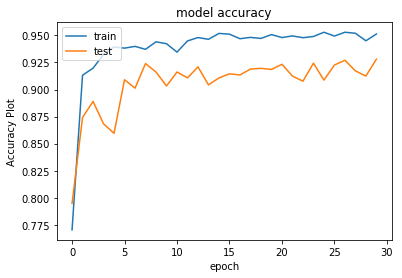

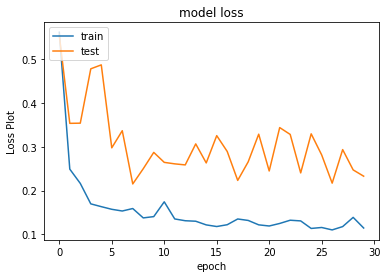

In [41]:
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [42]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(x_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 537        0         0        0                   0   
SITTING                  9      417        62        0                   0   
STANDING                 0      102       430        0                   0   
WALKING                  0        0         0      492                   0   
WALKING_DOWNSTAIRS       0        1         0        3                 410   
WALKING_UPSTAIRS         0        0         0        5                  17   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            3  
STANDING                           0  
WALKING                            4  
WALKING_DOWNSTAIRS                 6  
WALKING_UPSTAIRS                 449  


In [43]:
score = model.evaluate(x_test, Y_test)

2947/2947 [==============================] - 49s 17ms/step


In [44]:
score

[0.23298911445924328, 0.9280624363759755]

In [21]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(TimeDistributed(Conv1D(filters = 512, kernel_size=2,
                 activation='relu'), input_shape = (timesteps,input_dim,1)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.7)))

# model.add(TimeDistributed(Conv1D(filters = 512, kernel_size=3,
#                  activation='relu')))
# model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(Dropout(0.5)))

model.add(TimeDistributed(Flatten()))
model.add(TimeDistributed(Dense(512, activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.7)))
model.add(TimeDistributed(Dense(128, activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.4)))
model.add(LSTM(200, return_sequences=True))
model.add(Dropout(0.7))
model.add(LSTM(100))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='softmax'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 128, 8, 512)       1536      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 128, 4, 512)       0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 128, 4, 512)       2048      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 128, 4, 512)       0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 128, 2048)         0         
_________________________________________________________________
time_distributed_6 (T

In [22]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [23]:
# Training the model
history = model.fit(x_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(x_test, Y_test),
          epochs=epochs)

Instructions for updating:
Use tf.cast instead.
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 810s 110ms/step - loss: 0.5405 - acc: 0.7811 - val_loss: 0.5612 - val_acc: 0.8083
Epoch 2/30
7352/7352 [==============================] - 804s 109ms/step - loss: 0.3381 - acc: 0.8750 - val_loss: 0.6228 - val_acc: 0.8161
Epoch 3/30
7352/7352 [==============================] - 803s 109ms/step - loss: 0.2262 - acc: 0.9157 - val_loss: 0.3757 - val_acc: 0.8935
Epoch 4/30
7352/7352 [==============================] - 803s 109ms/step - loss: 0.2011 - acc: 0.9249 - val_loss: 0.3016 - val_acc: 0.8901
Epoch 5/30
7352/7352 [==============================] - 804s 109ms/step - loss: 0.2357 - acc: 0.9178 - val_loss: 0.3462 - val_acc: 0.8938
Epoch 6/30
7352/7352 [==============================] - 803s 109ms/step - loss: 0.1853 - acc: 0.9301 - val_loss: 0.2765 - val_acc: 0.9070
Epoch 7/30
7352/7352 [==============================] - 803s 109ms/step - lo

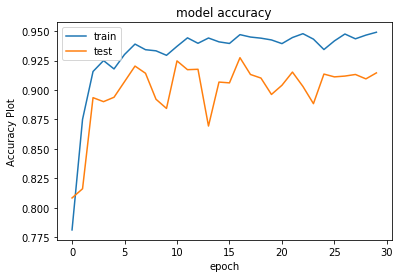

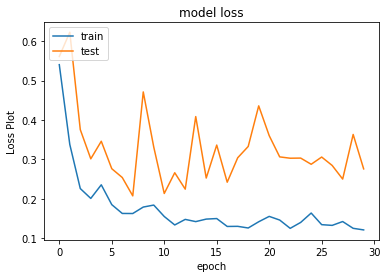

In [24]:
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(x_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0        27        0                   0   
SITTING                  2      415        65        0                   0   
STANDING                 0      102       428        0                   0   
WALKING                  0        0         0      463                   7   
WALKING_DOWNSTAIRS       0        0         0        1                 416   
WALKING_UPSTAIRS         0        1         0        2                   5   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            9  
STANDING                           2  
WALKING                           26  
WALKING_DOWNSTAIRS                 3  
WALKING_UPSTAIRS                 463  


In [26]:
score = model.evaluate(x_test, Y_test)

2947/2947 [==============================] - 74s 25ms/step


In [27]:
score

[0.2760810942916826, 0.9144893111638955]

In [39]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(TimeDistributed(Conv1D(filters = 32, kernel_size=4, padding = 'same',
                 activation='relu'), input_shape = (timesteps,input_dim,1)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.7)))

model.add(TimeDistributed(Conv1D(filters = 64, kernel_size=4,padding = 'same',
                 activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.5)))

model.add(TimeDistributed(Flatten()))
model.add(TimeDistributed(Dense(512, activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.7)))
model.add(LSTM(200, return_sequences=True))
model.add(Dropout(0.7))
model.add(LSTM(100))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_12 (TimeDis (None, 128, 9, 32)        160       
_________________________________________________________________
time_distributed_13 (TimeDis (None, 128, 4, 32)        0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, 128, 4, 32)        128       
_________________________________________________________________
time_distributed_15 (TimeDis (None, 128, 4, 32)        0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 128, 4, 64)        8256      
_________________________________________________________________
time_distributed_17 (TimeDis (None, 128, 2, 64)        0         
_________________________________________________________________
time_distributed_18 (TimeDis (None, 128, 2, 64)        256       
__________

In [40]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [41]:
# Training the model
history = model.fit(x_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(x_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 536s 73ms/step - loss: 0.7620 - acc: 0.6575 - val_loss: 0.6815 - val_acc: 0.7377
Epoch 2/30
7352/7352 [==============================] - 494s 67ms/step - loss: 0.4623 - acc: 0.8205 - val_loss: 0.4515 - val_acc: 0.8327
Epoch 3/30
7352/7352 [==============================] - 498s 68ms/step - loss: 0.3600 - acc: 0.8663 - val_loss: 0.3914 - val_acc: 0.8392
Epoch 4/30
7352/7352 [==============================] - 477s 65ms/step - loss: 0.3055 - acc: 0.8909 - val_loss: 0.2798 - val_acc: 0.8918
Epoch 5/30
7352/7352 [==============================] - 492s 67ms/step - loss: 0.2358 - acc: 0.9140 - val_loss: 0.3065 - val_acc: 0.8914
Epoch 6/30
7352/7352 [==============================] - 813s 111ms/step - loss: 0.2219 - acc: 0.9181 - val_loss: 0.3915 - val_acc: 0.8711
Epoch 7/30
7352/7352 [==============================] - 873s 119ms/step - loss: 0.2123 - acc: 0.9223 - val_loss: 0.3724 - val_acc

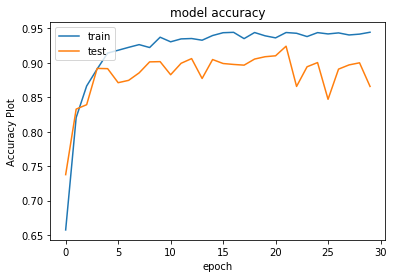

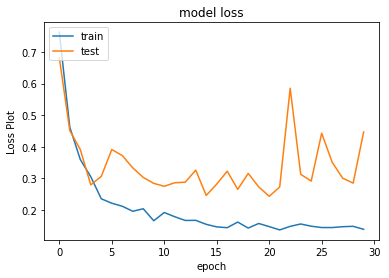

In [42]:
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [43]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(x_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 536        0         0        0                   0   
SITTING                  1      399        89        1                   0   
STANDING                 0       92       438        0                   0   
WALKING                  0        0         0      485                   7   
WALKING_DOWNSTAIRS       0        0         1       10                 393   
WALKING_UPSTAIRS         0        0         0      151                  20   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             1  
SITTING                            1  
STANDING                           2  
WALKING                            4  
WALKING_DOWNSTAIRS                16  
WALKING_UPSTAIRS                 300  


In [44]:
score = model.evaluate(x_test, Y_test)

2947/2947 [==============================] - 61s 21ms/step


In [45]:
score

[0.44704149100151447, 0.8656260604206327]

In [41]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(TimeDistributed(Conv1D(filters = 64, kernel_size=3, padding = 'same',
                 activation='relu'), input_shape = (timesteps,input_dim,1)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(Dropout(0.7)))

model.add(TimeDistributed(Conv1D(filters = 64, kernel_size=3,padding = 'same',
                 activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(Dropout(0.5)))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(180, return_sequences=True))
# Adding a dropout layer
model.add(Dropout(0.5))

model.add(LSTM(300))
# Adding a dropout layer
model.add(Dropout(0.8))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_7 (TimeDist (None, 128, 9, 64)        256       
_________________________________________________________________
time_distributed_8 (TimeDist (None, 128, 4, 64)        0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 128, 4, 64)        12352     
_________________________________________________________________
time_distributed_10 (TimeDis (None, 128, 2, 64)        0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 128, 2, 64)        256       
_________________________________________________________________
time_distributed_12 (TimeDis (None, 128, 128)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 128, 180)          222480    
__________

In [42]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [44]:
# Training the model
history = model.fit(x_train,
          Y_train,
          batch_size=100,
          validation_data=(x_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 360s 49ms/step - loss: 0.6486 - acc: 0.7297 - val_loss: 0.4679 - val_acc: 0.8470
Epoch 2/30
7352/7352 [==============================] - 292s 40ms/step - loss: 0.2559 - acc: 0.9112 - val_loss: 0.2944 - val_acc: 0.9006
Epoch 3/30
7352/7352 [==============================] - 290s 39ms/step - loss: 0.1642 - acc: 0.9411 - val_loss: 0.6482 - val_acc: 0.8558
Epoch 4/30
7352/7352 [==============================] - 289s 39ms/step - loss: 0.1683 - acc: 0.9378 - val_loss: 0.5072 - val_acc: 0.8412
Epoch 5/30
7352/7352 [==============================] - 288s 39ms/step - loss: 0.1542 - acc: 0.9410 - val_loss: 0.3598 - val_acc: 0.8500
Epoch 6/30
7352/7352 [==============================] - 290s 39ms/step - loss: 0.1479 - acc: 0.9406 - val_loss: 0.3146 - val_acc: 0.9026
Epoch 7/30
7352/7352 [==============================] - 290s 39ms/step - loss: 0.1723 - acc: 0.9387 - val_loss: 0.4053 - val_acc: 

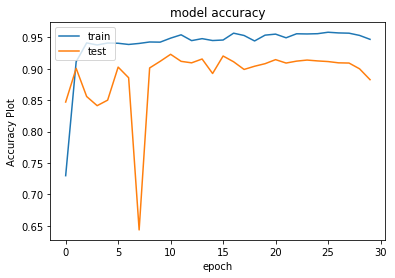

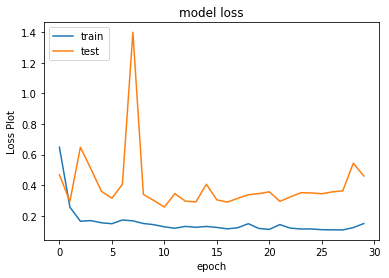

In [45]:
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [46]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(x_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 494        0         0        0                   0   
SITTING                  0      301       184        0                   0   
STANDING                 0       38       491        1                   1   
WALKING                  0        0         0      474                   9   
WALKING_DOWNSTAIRS       0        0         0        2                 393   
WALKING_UPSTAIRS         0        0         0        1                  22   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            43  
SITTING                            6  
STANDING                           1  
WALKING                           13  
WALKING_DOWNSTAIRS                25  
WALKING_UPSTAIRS                 448  


In [47]:
score = model.evaluate(x_test, Y_test)

2947/2947 [==============================] - 49s 17ms/step


In [48]:
score

[0.46009989105978805, 0.8825924669155073]

In [137]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model","n_hidden","Dropout", "Train Accuracy", "Test Accuracy"]

x.add_row(["1 Layer LSTM model",32,0.7, 0.9449, 0.8985])
x.add_row(["1 Layer LSTM model",40,0.5, 0.9455, 0.9070])
x.add_row(["1 Layer LSTM model",50,0.6, 0.9506, 0.9152])
x.add_row(["1 Layer LSTM model",60,0.7, 0.9489, 0.9152])
x.add_row(["1 Layer LSTM model + Batch normalization",40,0.7, 0.1668, 0.1683])
x.add_row(["2 Layer LSTM",40,"0.5 and 0.6", 0.9436, 0.9118])
x.add_row(["2 Layer LSTM",40,"0.6 and 0.5", 0.9323, 0.9074])
x.add_row(["2 Layer LSTM",50,"0.5 and 0.6", 0.9396, 0.8931])
x.add_row(["2 Layer LSTM",60,"0.7 and 0.6", 0.9445, 0.9090])

print(x.get_string(title="Multiple LSTM Model"),'\n')

+----------------------------------------------------------------------------------------------------+
|                                        Multiple LSTM Model                                         |
+------------------------------------------+----------+-------------+----------------+---------------+
|                  Model                   | n_hidden |   Dropout   | Train Accuracy | Test Accuracy |
+------------------------------------------+----------+-------------+----------------+---------------+
|            1 Layer LSTM model            |    32    |     0.7     |     0.9449     |     0.8985    |
|            1 Layer LSTM model            |    40    |     0.5     |     0.9455     |     0.907     |
|            1 Layer LSTM model            |    50    |     0.6     |     0.9506     |     0.9152    |
|            1 Layer LSTM model            |    60    |     0.7     |     0.9489     |     0.9152    |
| 1 Layer LSTM model + Batch normalization |    40    |     0.7     |    

## Deep LSTM

In [18]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(300, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
# model.add(BatchNormalization())
model.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='softmax'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 300)               372000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1806      
Total params: 373,806
Trainable params: 373,806
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [21]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=50,
          validation_data=(X_test, Y_test),
          epochs=40)

Train on 7352 samples, validate on 2947 samples
Epoch 1/40
7352/7352 [==============================] - 136s 19ms/step - loss: 0.8254 - acc: 0.6473 - val_loss: 0.6873 - val_acc: 0.6658
Epoch 2/40
7352/7352 [==============================] - 138s 19ms/step - loss: 0.5945 - acc: 0.7782 - val_loss: 0.6460 - val_acc: 0.7401
Epoch 3/40
7352/7352 [==============================] - 137s 19ms/step - loss: 0.4970 - acc: 0.8464 - val_loss: 1.9378 - val_acc: 0.4004
Epoch 4/40
7352/7352 [==============================] - 136s 19ms/step - loss: 0.4364 - acc: 0.8577 - val_loss: 0.4281 - val_acc: 0.8493
Epoch 5/40
7352/7352 [==============================] - 137s 19ms/step - loss: 0.2664 - acc: 0.9071 - val_loss: 0.2857 - val_acc: 0.9084
Epoch 6/40
7352/7352 [==============================] - 136s 19ms/step - loss: 0.2359 - acc: 0.9187 - val_loss: 1.3450 - val_acc: 0.7221
Epoch 7/40
7352/7352 [==============================] - 136s 18ms/step - loss: 0.2510 - acc: 0.9173 - val_loss: 0.2685 - val_acc: 

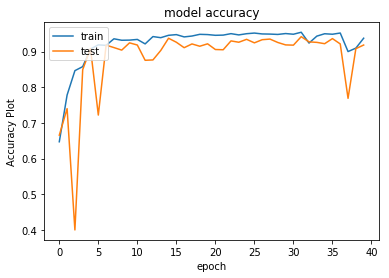

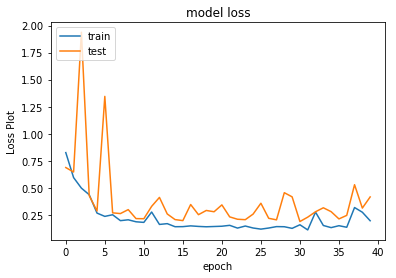

In [22]:
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 534        0         0        0                   0   
SITTING                  5      401        79        0                   0   
STANDING                 0      104       423        0                   0   
WALKING                  0        9         0      460                  27   
WALKING_DOWNSTAIRS       0        0         0        0                 420   
WALKING_UPSTAIRS         0        0         0        0                   3   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             3  
SITTING                            6  
STANDING                           5  
WALKING                            0  
WALKING_DOWNSTAIRS                 0  
WALKING_UPSTAIRS                 468  


In [24]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 11s 4ms/step


In [25]:
score

[0.41566183432702536, 0.9182219205972175]

In [26]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(500, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
# model.add(BatchNormalization())
model.add(Dropout(0.8))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 500)               1020000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 3006      
Total params: 1,023,006
Trainable params: 1,023,006
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [29]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=100,
          validation_data=(X_test, Y_test),
          epochs=30)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 459s 62ms/step - loss: 0.8119 - acc: 0.7417 - val_loss: 0.7853 - val_acc: 0.7007
Epoch 2/30
7352/7352 [==============================] - 478s 65ms/step - loss: 0.5914 - acc: 0.8024 - val_loss: 0.4978 - val_acc: 0.8225
Epoch 3/30
7352/7352 [==============================] - 480s 65ms/step - loss: 0.3966 - acc: 0.8706 - val_loss: 0.4444 - val_acc: 0.8422
Epoch 4/30
7352/7352 [==============================] - 481s 65ms/step - loss: 0.2775 - acc: 0.9061 - val_loss: 0.4032 - val_acc: 0.8609
Epoch 5/30
7352/7352 [==============================] - 480s 65ms/step - loss: 0.2560 - acc: 0.9102 - val_loss: 0.3030 - val_acc: 0.8894
Epoch 6/30
7352/7352 [==============================] - 484s 66ms/step - loss: 1.0551 - acc: 0.7281 - val_loss: 0.4085 - val_acc: 0.8704
Epoch 7/30
7352/7352 [==============================] - 496s 68ms/step - loss: 0.2932 - acc: 0.9061 - val_loss: 0.3511 - val_acc: 

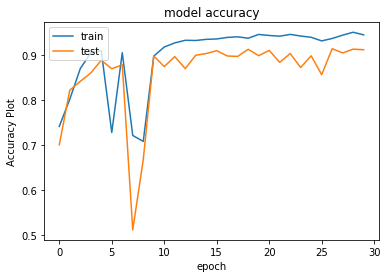

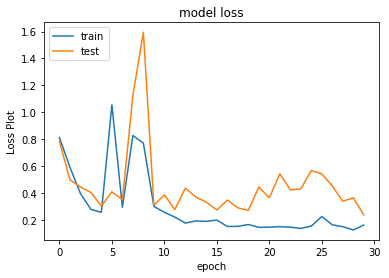

In [30]:
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 537        0         0        0                   0   
SITTING                  0      403        85        0                   0   
STANDING                 0      108       423        1                   0   
WALKING                  0       10         0      465                   9   
WALKING_DOWNSTAIRS       0        0         0        1                 418   
WALKING_UPSTAIRS         0        1         0        9                  17   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            3  
STANDING                           0  
WALKING                           12  
WALKING_DOWNSTAIRS                 1  
WALKING_UPSTAIRS                 444  


In [32]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 32s 11ms/step


In [33]:
score

[0.237533324331902, 0.9127926705123854]

In [ ]:
# 1 layer LSTM with 60 hidden unit and dropout of 0.7 gives 91.52% accuracy on TEst data.

In [49]:
!pip install hyperas

In [98]:
from __future__ import print_function
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

In [85]:
def data():
    return x_train,Y_train,x_test,Y_test

In [84]:
print(data().shape)

(7352, 128, 9, 1)


In [66]:
input_dim

9

In [77]:
n_classes

6

In [95]:
# Initiliazing the sequential model
def model(x_train, Y_train, x_test, Y_test):
#     global timesteps
    timesteps = 128
    input_dim = 9
    n_classes = 6
    x_train,Y_train,x_test,Y_test = data()
#     print(timesteps)
    model = Sequential()
    # Configuring the parameters
    model.add(TimeDistributed(Conv1D(filters = {{choice([64,128, 256, 512, 1024])}}, kernel_size={{choice([2,3,4,5])}},
                     activation={{choice(['relu', 'sigmoid'])}},padding = 'same'), input_shape = (timesteps,input_dim,1)))
    model.add(TimeDistributed(MaxPooling1D(pool_size={{choice([2,3,4,5])}})))
    # model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Dropout({{uniform(0, 1)}})))

    model.add(TimeDistributed(Conv1D(filters = {{choice([64,128, 256, 512, 1024])}}, kernel_size={{choice([2,3,4,5])}},
                     activation={{choice(['relu', 'sigmoid'])}},padding = 'same')))
    model.add(TimeDistributed(MaxPooling1D(pool_size={{choice([2,3,4,5])}})))
    # model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Dropout({{uniform(0, 1)}})))

    if {{choice(['two', 'three'])}} == 'three':
        model.add(TimeDistributed(Conv1D(filters = {{choice([64,128, 256, 512, 1024])}}, kernel_size={{choice([2,3,4,5])}},
                     activation={{choice(['relu', 'sigmoid'])}},padding = 'same')))
        model.add(TimeDistributed(MaxPooling1D(pool_size={{choice([2,3,4,5])}})))
    # model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Dropout({{uniform(0, 1)}})))

    model.add(TimeDistributed(Flatten()))
    model.add(LSTM({{choice([64,128, 256, 512, 1024])}}, return_sequences=True))
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(LSTM({{choice([64,128, 256, 512, 1024])}}))
    # Adding a dropout layer
    model.add(Dropout({{uniform(0, 1)}}))
    # Adding a dense output layer with sigmoid activation
    model.add(Dense(n_classes, activation='softmax'))
    
    adam = keras.optimizers.Adam(lr={{choice([10**-3, 10**-2, 10**-1])}})
    rmsprop = keras.optimizers.RMSprop(lr={{choice([10**-3, 10**-2, 10**-1])}})
    sgd = keras.optimizers.SGD(lr={{choice([10**-3, 10**-2, 10**-1])}})
   
    choiceval = {{choice(['adam', 'sgd', 'rmsprop'])}}
    if choiceval == 'adam':
        optim = adam
    elif choiceval == 'rmsprop':
        optim = rmsprop
    else:
        optim = sgd
        
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=optim)
    model.fit(x_train, Y_train,
              batch_size={{choice([16,64,128,256,512])}},
              nb_epoch=20,
              verbose=2,
              validation_data=(x_test, Y_test))
    score, acc = model.evaluate(x_test, Y_test, verbose=0)
    print('Test accuracy:', acc)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}
    

In [99]:
# 
# print(x_train)
if __name__ == '__main__':
    best_run, best_model = optim.minimize(model=model,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=30,
                                          trials=Trials(),
                                         notebook_name='HAR_LSTM')

>>> Imports:
#coding=utf-8

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    from keras.layers.normalization import BatchNormalization
except:
    pass

try:
    import keras
except:
    pass

try:
    from keras import backend as K
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import LSTM, Conv1D, Conv2D, TimeDistributed, MaxPooling1D, MaxPooling2D
except:
    pass

try:
    from keras.layers.core import Dense, Dropout, Flatten
except:
    pass

try:
    from keras.layers.normalization import BatchNormalization
except:
    pass

try:
    from prettytable import PrettyTable
except:
    pass

from __future__ import print_function

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from

SyntaxError: from __future__ imports must occur at the beginning of the file (temp_model.py, line 63)

In [ ]:
def model(X_train, Y_train, X_val, Y_val):
    
    model = Sequential()
    model.add(Dense({{choice([128, 256, 512, 1024])}}, input_shape=(784,)))
    model.add(Activation({{choice(['relu', 'sigmoid'])}}))
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(Dense({{choice([128, 256, 512, 1024])}}))
    model.add(Activation({{choice(['relu', 'sigmoid'])}}))
    model.add(Dropout({{uniform(0, 1)}}))
    
    if conditional({{choice(['two', 'three'])}}) == 'three':
        model.add(Dense({{choice([128, 256, 512, 1024])}}))
        model.add(Activation({{choice(['relu', 'sigmoid'])}}))
        model.add(Dropout({{uniform(0, 1)}}))
        
    model.add(Dense(10))
    model.add(Activation('softmax'))
    adam = keras.optimizers.Adam(lr={{choice([10**-3, 10**-2, 10**-1])}})
    rmsprop = keras.optimizers.RMSprop(lr={{choice([10**-3, 10**-2, 10**-1])}})
    sgd = keras.optimizers.SGD(lr={{choice([10**-3, 10**-2, 10**-1])}})
   
    choiceval = {{choice(['adam', 'sgd', 'rmsprop'])}}
    if choiceval == 'adam':
        optim = adam
    elif choiceval == 'rmsprop':
        optim = rmsprop
    else:
        optim = sgd
        
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=optim)
    model.fit(X_train, Y_train,
              batch_size={{choice([128,256,512])}},
              nb_epoch=20,
              verbose=2,
              validation_data=(X_val, Y_val))
    score, acc = model.evaluate(X_val, Y_val, verbose=0)
    print('Test accuracy:', acc)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}